# Aircraft Sightings Over Time

This notebook calculates and exports:

- Daily and daily rolling average aircraft sightings over time
- Monthly sightings over time
- Yearly sightings over time

To use it, set the daily rolling average window length and the export format for the charts in the first code cell before running the notebook.

In [8]:
# Window for daily rolling average calculation
window = 7

# Export format for the charts:
# PNG     - export as PNG image
# PDF     - export as PDF file
# <blank> - do not export
export_format = "PNG"

In [9]:
from pathlib import Path
import sqlparse

# Read the query file
query_file_path = Path("sql") / "sightings.sql"
with open(query_file_path.absolute(), "r") as f:
    query = f.read().replace("\n", " ")

# Show a pretty-printed form of the query
print(sqlparse.format(query, reindent=True, keyword_case='upper'))

SELECT DATE(s.Date) AS 'Date',
       l.Name AS 'Location',
       a.Name AS 'Airline',
       f.Number,
       f.Embarkation,
       f.Destination,
       ac.Registration,
       ac.Serial_Number,
       mo.Name AS 'Model',
       m.Name AS 'Manufacturer'
FROM SIGHTING s
INNER JOIN LOCATION l ON l.Id = s.Location_Id
INNER JOIN FLIGHT f ON f.Id = s.Flight_Id
INNER JOIN AIRLINE a ON a.Id = f.Airline_Id
INNER JOIN AIRCRAFT ac ON ac.Id = s.Aircraft_Id
INNER JOIN MODEL mo ON mo.Id = ac.Model_Id
INNER JOIN MANUFACTURER m ON m.Id = mo.Manufacturer_Id;


In [10]:
import pandas as pd
import sqlite3
import os

# Connect to the database, execute the query and read the results into a dataframe
database_path = os.environ["FLIGHT_RECORDER_DB"]
connection = sqlite3.connect(database_path)
df = pd.read_sql_query(query, connection, parse_dates=["Date"])

# Check there is some data
if not df.shape[0]:
    message = f"No data found"
    raise ValueError(message)

In [11]:
# Aggregate sightings
daily = df.groupby(df["Date"].dt.date).size().rename("Sightings")
monthly = df.groupby(df["Date"].dt.to_period("M")).size().rename("Sightings")
yearly = df.groupby(df["Date"].dt.year).size().rename("Sightings")

# Calculate a roling average for the daily data
daily_rolling = daily.rolling(window=window).mean()

In [12]:
# Create the folder to hold exported reports
export_folder_path = Path("exported")
export_folder_path.mkdir(parents=True, exist_ok=True)

# Create a Pandas Excel writer
export_file_name = "Aircraft-Sightings-Over-Time"
output_path = export_folder_path / f"{export_file_name}.xlsx"

with pd.ExcelWriter(output_path.absolute(), engine="openpyxl") as writer:
    # Daily data
    daily.to_frame(name="Sightings").to_excel(writer, sheet_name="Daily")
    daily_rolling.to_frame(name="Sightings").to_excel(writer, sheet_name="Daily Rolling Average")
    
    # Monthly data (convert PeriodIndex to Timestamp)
    monthly.index = monthly.index.to_timestamp()
    monthly.to_frame(name="Sightings").to_excel(writer, sheet_name="Monthly")
    
    # Yearly data
    yearly.to_frame(name="Sightings").to_excel(writer, sheet_name="Yearly")

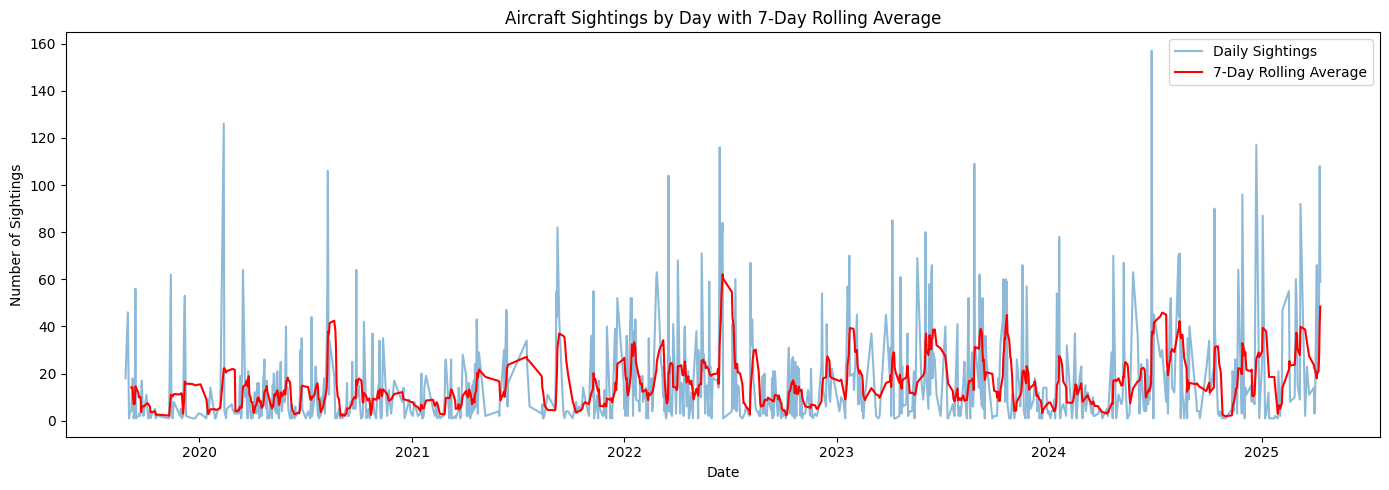

In [13]:
import matplotlib.pyplot as plt

# Plot the daily statistics
plt.figure(figsize=(14, 5))
plt.plot(daily.index, daily.values, label="Daily Sightings", alpha=0.5)
plt.plot(daily_rolling.index, daily_rolling.values, label=f"{window}-Day Rolling Average", color='red')
plt.title(f"Aircraft Sightings by Day with {window}-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Number of Sightings")
plt.legend()
plt.tight_layout()

# Export to PNG
if export_format.casefold() == "png":
    export_file_path = export_folder_path / f"{export_file_name}-Daily.png"
    plt.savefig(export_file_path.absolute(), format="png", dpi=300, bbox_inches="tight")

# Export to PDF
if export_format.casefold() == "pdf":
    export_file_path = export_folder_path / f"{export_file_name}-Daily.pdf"
    plt.savefig(export_file_path.absolute(), format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

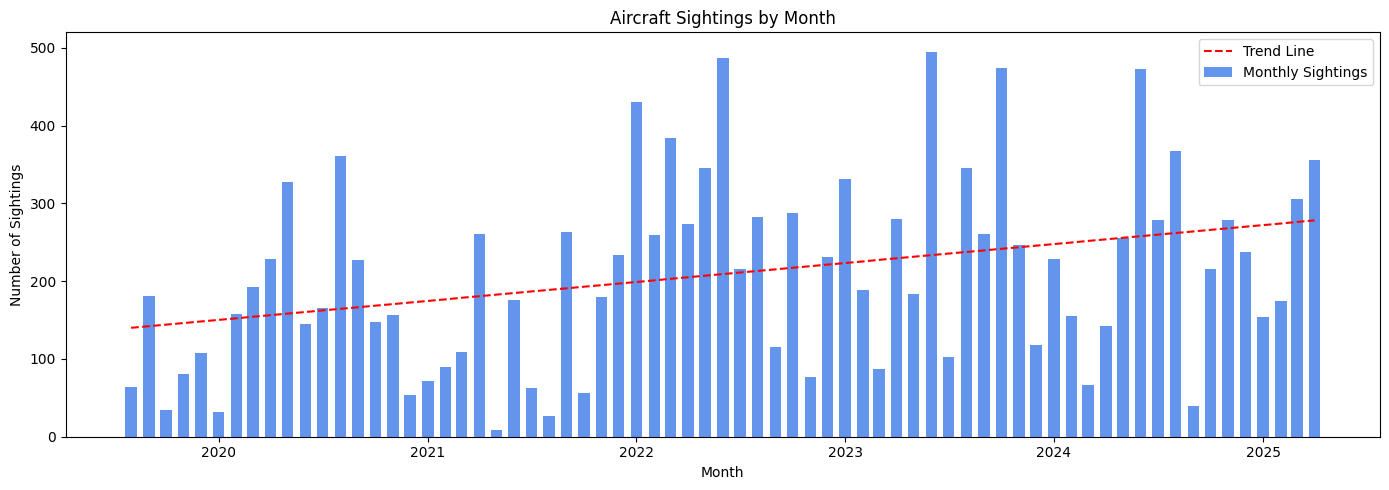

In [14]:
import numpy as np
from scipy.stats import linregress

# The monthly data index has been converted to a timestamp, above, for export
x = np.arange(len(monthly.index))  # numerical x-axis for regression
y = monthly.values

# Calculate the monthly trend line
slope, intercept, r_value, p_value, std_err = linregress(x, y)
trend = slope * x + intercept

# Plot sightings by month with trend line
plt.figure(figsize=(14, 5))
# plt.plot(monthly_index, y, label="Monthly Sightings", marker="o")
plt.bar(monthly.index, y, width=20, label="Monthly Sightings", color="cornflowerblue")
plt.plot(monthly.index, trend, label="Trend Line", linestyle="--", color="red")
plt.title("Aircraft Sightings by Month")
plt.xlabel("Month")
plt.ylabel("Number of Sightings")
plt.legend()
plt.tight_layout()

# Export to PNG
if export_format.casefold() == "png":
    export_file_path = export_folder_path / f"{export_file_name}-Monthly.png"
    plt.savefig(export_file_path.absolute(), format="png", dpi=300, bbox_inches="tight")

# Export to PDF
if export_format.casefold() == "pdf":
    export_file_path = export_folder_path / f"{export_file_name}-Monthly.pdf"
    plt.savefig(export_file_path.absolute(), format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

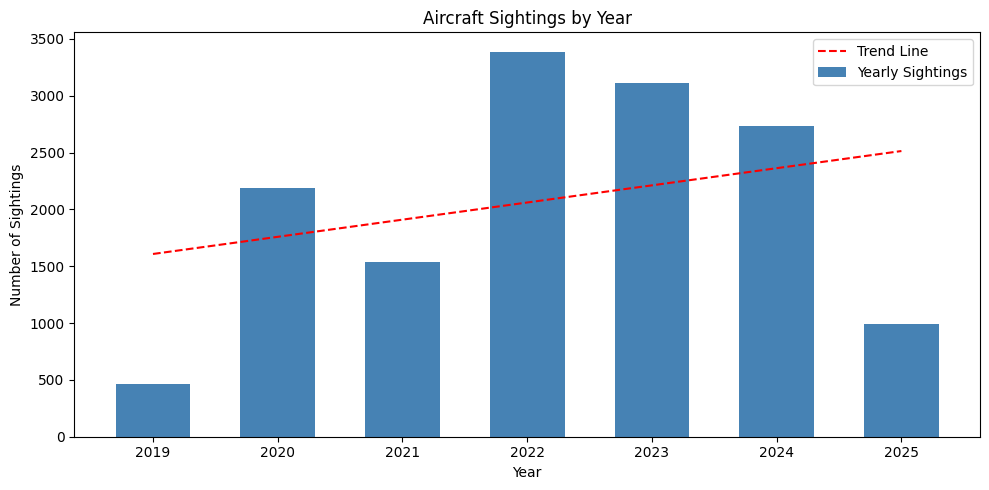

In [15]:
# Plot Sightings by Year with Trend Line
x = yearly.index.values
y = yearly.values
slope, intercept, r_value, p_value, std_err = linregress(x, y)

plt.figure(figsize=(10, 5))
# sns.lineplot(x=x, y=y, marker="o", label="Sightings per Year")
plt.bar(x, y, color="steelblue", width=0.6, label="Yearly Sightings")
plt.plot(x, slope * x + intercept, color="red", linestyle="--", label="Trend Line")
plt.title("Aircraft Sightings by Year")
plt.xlabel("Year")
plt.ylabel("Number of Sightings")
plt.legend()
plt.tight_layout()

# Export to PNG
if export_format.casefold() == "png":
    export_file_path = export_folder_path / f"{export_file_name}-Yearly.png"
    plt.savefig(export_file_path.absolute(), format="png", dpi=300, bbox_inches="tight")

# Export to PDF
if export_format.casefold() == "pdf":
    export_file_path = export_folder_path / f"{export_file_name}-Yearly.pdf"
    plt.savefig(export_file_path.absolute(), format="pdf", bbox_inches="tight")

# Show the plot
plt.show()